# Mode-Mixing due to PCA

In this notebook, we give a synopsis of the mode-mixing effect described in [Chen 2025](https://arxiv.org/abs/2504.13070), and how to use `meer21cm` to generate mode-mixing effects that you can apply to your power spectrum modelling.

In [42]:
from meer21cm import MockSimulation
import numpy as np
import matplotlib.pyplot as plt
from meer21cm.transfer import analytic_transfer_function
from meer21cm.util import redshift_to_freq, pca_clean

Let us first generate some simple HI simulation in a rectangular box to demonstrate this effect. To capture the survey volume more or less, consider a 50 x 50 deg^2 area from z~0.5-1.5:

In [8]:
z_min = 0.5
z_max = 1.5
nu_max = redshift_to_freq(z_min)
nu_min = redshift_to_freq(z_max)
nu = np.linspace(nu_min,nu_max,100)

mock = MockSimulation(
    nu=nu,
    tracer_bias_1=1.5,
    mean_amp_1='average_hi_temp',
    omega_hi=5e-4,
)
# roughly 50 deg 
box_xy = 50 * np.pi / 180 * mock.comoving_distance(mock.z_ch.mean()).value #Mpc
box_z = (mock.comoving_distance(mock.z_ch.max()) - mock.comoving_distance(mock.z_ch.min())).value #Mpc
mock._box_len = np.array([box_xy,box_xy,box_z])
mock._box_ndim = np.array([100,100,100])
mock.propagate_field_k_to_model()

`meer21cm` can generate some HI box using lognormal simulations:

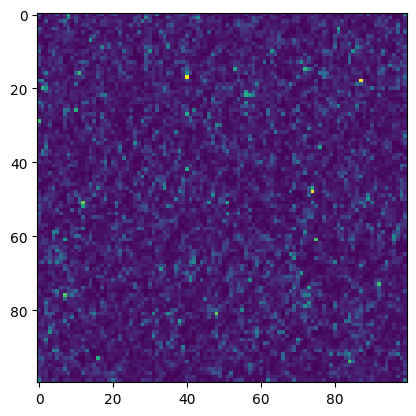

In [10]:
mock.mock_tracer_field_1;
plt.imshow(mock.mock_tracer_field_1[0])

You can pass the lognormal simulation back to `meer21cm` for power spectrum estimation:

Text(0, 0.5, 'P(k) [K^2 Mpc^3]')

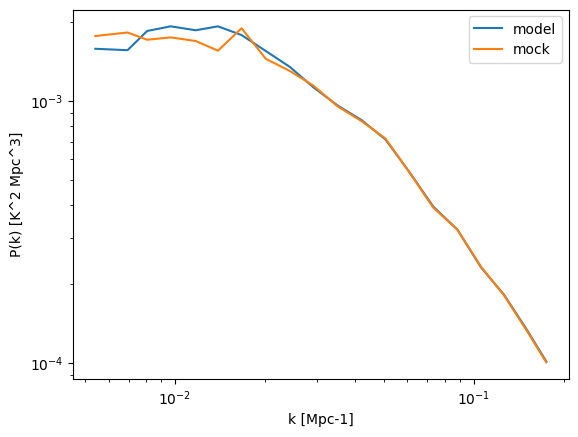

In [21]:
mock.field_1 = mock.mock_tracer_field_1
mock.k1dbins = np.geomspace(5e-3, 0.2, 21)
pmodel_1d, keff, _ = mock.get_1d_power(mock.auto_power_tracer_1_model)
pmock_1d, _, _ = mock.get_1d_power(mock.auto_power_3d_1)
plt.plot(keff,pmodel_1d,label='model')
plt.plot(keff,pmock_1d,label='mock')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k [Mpc-1]')
plt.ylabel('P(k) [K^2 Mpc^3]')

Let us run 100 realisations to retrieve some covariance:

In [27]:
pmock_arr = []
for seed in range(100):
    mock.seed = seed
    # trigger a reset of cache to rerun mock
    mock.tracer_bias_1 = 1.5
    mock.field_1 = mock.mock_tracer_field_1
    pmock_1d, _, _ = mock.get_1d_power(mock.auto_power_3d_1)
    pmock_arr.append(pmock_1d)

pmock_arr = np.array(pmock_arr)
    

Text(0, 0.5, 'P(k) [K^2 Mpc^3]')

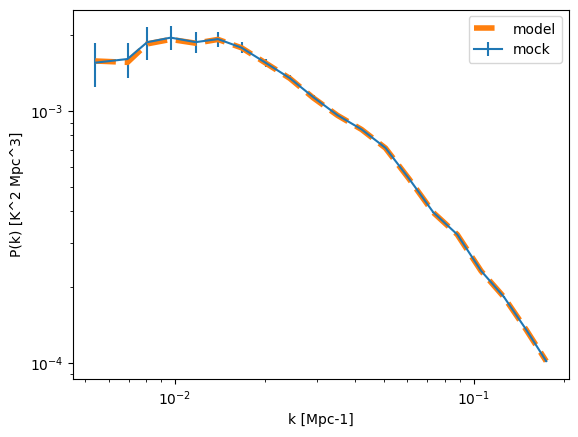

In [33]:
plt.errorbar(keff,pmock_arr.mean(axis=0),yerr=pmock_arr.std(axis=0),label='mock',)
plt.plot(keff,pmodel_1d,label='model',ls='--',lw=4)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k [Mpc-1]')
plt.ylabel('P(k) [K^2 Mpc^3]')

In [37]:
cov_mock = np.cov(pmock_arr.T)
corr_mock = np.corrcoef(pmock_arr.T)

The correlation between the k-bins is strong at large k. This is a feature of lognormal mocks:

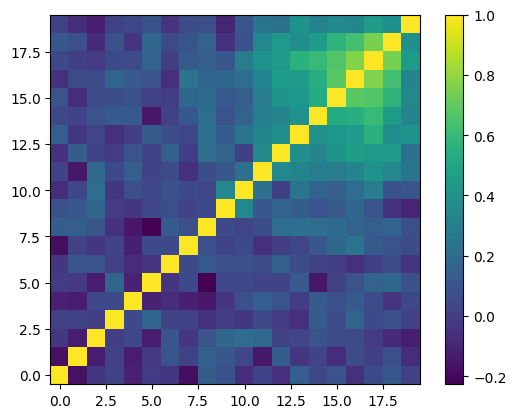

In [39]:
plt.imshow(corr_mock,origin='lower')
plt.colorbar()

Now let us do some naive PCA. We will simply at a uniform fg with constant spectral index. To illustrate the effect, let's also remove a large number of modes (15):

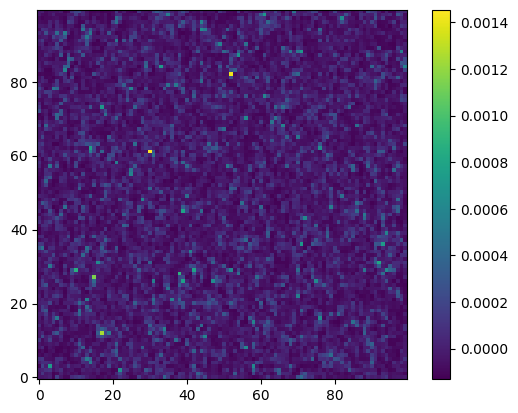

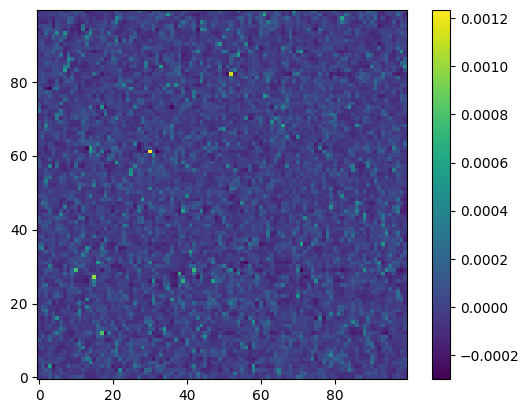

In [76]:
fg = 20 * (nu[None,None,:]/408/1e6)**(-2.7) * np.ones(mock.box_ndim)
N_fg = 15
res_map, A_mat = pca_clean(mock.mock_tracer_field_1+fg, N_fg, return_A=True)
plt.imshow(mock.mock_tracer_field_1[0],origin='lower')
plt.colorbar()
plt.figure()
plt.imshow(res_map[0],origin='lower')
plt.colorbar()

We can compare the cleaned ps with original:

In [77]:
mock.field_1 = mock.mock_tracer_field_1
pmock_orig, keff, _ = mock.get_1d_power(mock.auto_power_3d_1)
mock.field_1 = res_map
pmock_pca, keff, _ = mock.get_1d_power(mock.auto_power_3d_1)

Text(0, 0.5, 'P(k) [K^2 Mpc^3]')

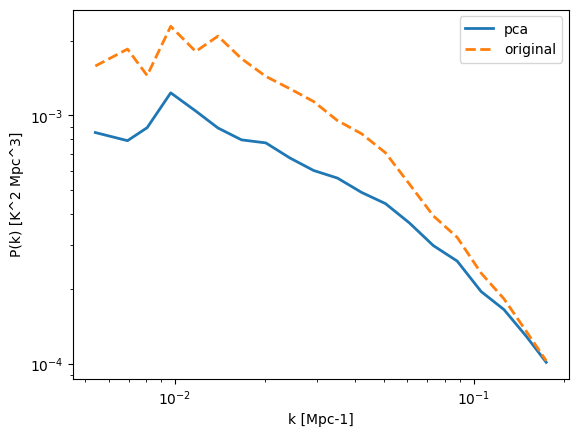

In [78]:
plt.plot(keff,pmock_pca,label='pca',ls='-',lw=2)
plt.plot(keff,pmock_orig,label='original',ls='--',lw=2)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k [Mpc-1]')
plt.ylabel('P(k) [K^2 Mpc^3]')

You can see that there is a "signal loss" (which is in fact both signal loss and mode-mixing).

Following the derivation in Chen 2025, `meer21cm` provides a functionality to calculate the window function and convolve it to the model:

In [79]:
R_pca = np.eye(A_mat.shape[0]) - A_mat @ A_mat.T
tf, wab = analytic_transfer_function(R_pca, R_pca)
hab = np.diag(1/tf) @ wab
pmodel_pca_corrected, keff, _ = mock.get_1d_power(
    np.einsum('ij, abj->abi',hab, mock.auto_power_tracer_1_model)
)


Text(0, 0.5, 'P(k) [K^2 Mpc^3]')

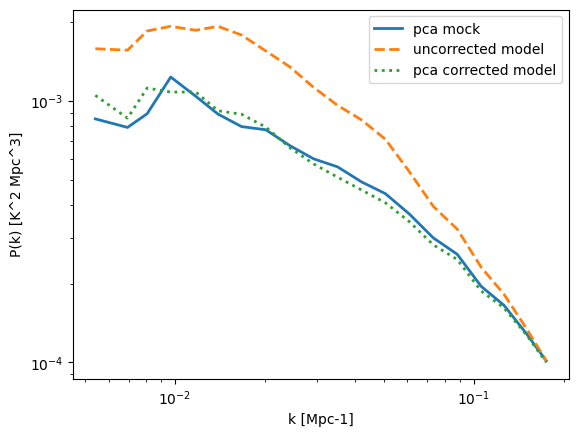

In [83]:
plt.plot(keff,pmock_pca,label='pca mock',ls='-',lw=2)
plt.plot(keff,pmodel_1d,label='uncorrected model',ls='--',lw=2)
plt.plot(keff,pmodel_pca_corrected,label='pca corrected model',ls=':',lw=2)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k [Mpc-1]')
plt.ylabel('P(k) [K^2 Mpc^3]')

Note again, that there is not just a signal loss but also a mode-mixing. Let us rerun the covariance calculation:

In [81]:
pmock_pca_arr = []
for seed in range(100):
    mock.seed = seed
    # trigger a reset of cache to rerun mock
    mock.tracer_bias_1 = 1.5
    res_map = pca_clean(mock.mock_tracer_field_1 + fg, N_fg)
    mock.field_1 = res_map
    pmock_1d, _, _ = mock.get_1d_power(mock.auto_power_3d_1)
    pmock_pca_arr.append(pmock_1d)

pmock_pca_arr = np.array(pmock_pca_arr)
    

Text(0, 0.5, 'P(k) [K^2 Mpc^3]')

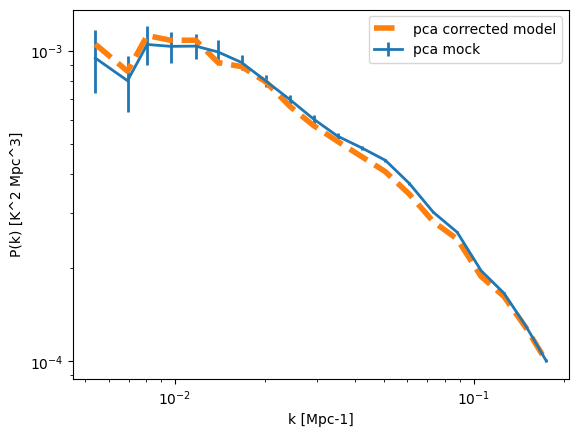

In [84]:
plt.errorbar(keff,pmock_pca_arr.mean(axis=0),yerr=pmock_pca_arr.std(axis=0),label='pca mock',ls='-',lw=2)
plt.plot(keff,pmodel_pca_corrected,label='pca corrected model',ls='--',lw=4)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k [Mpc-1]')
plt.ylabel('P(k) [K^2 Mpc^3]')

In [85]:
corr_pca_mock = np.corrcoef(pmock_pca_arr.T)

Text(0.5, 1.0, 'pca mock')

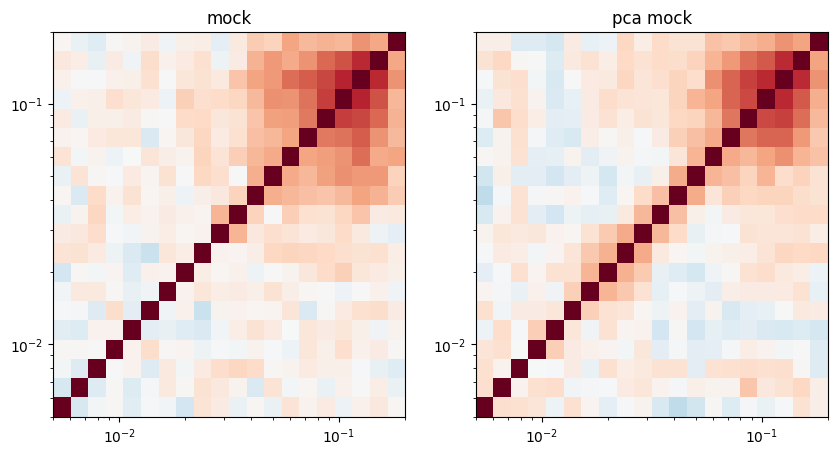

In [90]:
fig,axes = plt.subplots(1,2,figsize=(10,5))
axes[0].pcolormesh(mock.k1dbins, mock.k1dbins, corr_mock,vmin=-1,vmax=1,cmap='RdBu_r')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_title('mock')
axes[1].pcolormesh(mock.k1dbins, mock.k1dbins, corr_pca_mock,vmin=-1,vmax=1,cmap='RdBu_r')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_title('pca mock')

You can see that there is visible correlation at relatively large scales, induced by PCA.